In [1]:
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
root_dir = 'C:/Users/frank/data_analysis/age-classification'
path = root_dir + '/archive/train/' #이미지 경로
image_folders = os.listdir(path)
image_folders.pop(0)
image_paths = [path+image_folder for image_folder in image_folders]
modified_path = root_dir + '/dataset_real_real_filtered/' #샘플링된 이미지가 저장될 경로
modified_image_paths = [modified_path+image_folder for image_folder in image_folders]

In [3]:
# modified_path : archive_sample100. 100개 데이터만 샘플링한 것
# 데이터를 바꾸고 싶으면 data_dir에 들어가는 path를 다른 것으로 바꿔주면 됨
data_dir = modified_path
img_height, img_width = 224, 224
batch_size = 32

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 13729 files belonging to 53 classes.
Using 10984 files for training.
Found 13729 files belonging to 53 classes.
Using 2745 files for validation.


In [5]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


## Base Model

In [6]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

IMG_SHAPE = (img_height, img_width) + (3,)
base_model = tf.keras.applications.resnet.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

In [7]:
for image_batch, label_batch in train_ds:
    feature_batch = base_model(image_batch)
    print(feature_batch.shape)
    break

(32, 7, 7, 2048)


In [8]:
# 처음엔 base model은 train 안되게끔 하고, 임의로 맨 위층에 추가하는 layer만 train
# fine tuning하기 전 last layer를 한 번 train해줘야 한다고 함
base_model.trainable = False

In [9]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

conv2_block3_out (Activation)   (None, 56, 56, 256)  0           conv2_block3_add[0][0]           
__________________________________________________________________________________________________
conv3_block1_1_conv (Conv2D)    (None, 28, 28, 128)  32896       conv2_block3_out[0][0]           
__________________________________________________________________________________________________
conv3_block1_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_1_relu (Activation (None, 28, 28, 128)  0           conv3_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block1_2_conv (Conv2D)    (None, 28, 28, 128)  147584      conv3_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_bloc

__________________________________________________________________________________________________
conv3_block4_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_add (Add)          (None, 28, 28, 512)  0           conv3_block3_out[0][0]           
                                                                 conv3_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 28, 28, 512)  0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, 14, 14, 256)  131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block4_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_2_relu (Activation (None, 14, 14, 256)  0           conv4_block4_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block4_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block4_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block4_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_add (Add)          (None, 14, 14, 1024) 0           conv4_block3_out[0][0]           
          

__________________________________________________________________________________________________
conv5_block2_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_1_relu (Activation (None, 7, 7, 512)    0           conv5_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block2_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_relu (Activation (None, 7, 7, 512)    0           conv5_block2_2_bn[0][0]          
__________

In [10]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [11]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss='mse',
              metrics=['mae'])

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [13]:
# callback함수를 이용해서 epoch 5번마다 checkpoint 생성
# 파일 이름에 에포크 번호를 포함시킵니다(`str.format` 포맷)
checkpoint_path = "CP_ResNet50_Sample100_Filtered/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 다섯 번째 에포크마다 가중치를 저장하기 위한 콜백을 만듭니다
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

In [14]:
model.save_weights(checkpoint_path.format(epoch=0))

In [15]:
history = model.fit(train_ds,
                     epochs=10,
                     validation_data=val_ds)

Epoch 1/10


186/344 [===============>..............] - ETA: 53:19 - loss: 513.7959 - mae: 19.884 - ETA: 18:44 - loss: 493.4215 - mae: 18.728 - ETA: 20:19 - loss: 456.4875 - mae: 17.626 - ETA: 21:25 - loss: 425.5856 - mae: 17.077 - ETA: 23:38 - loss: 378.2778 - mae: 15.795 - ETA: 24:15 - loss: 352.7556 - mae: 15.214 - ETA: 24:49 - loss: 337.3635 - mae: 14.961 - ETA: 26:21 - loss: 320.2980 - mae: 14.588 - ETA: 28:32 - loss: 305.9252 - mae: 14.327 - ETA: 29:28 - loss: 297.0132 - mae: 14.191 - ETA: 30:14 - loss: 290.5302 - mae: 14.080 - ETA: 30:44 - loss: 276.1675 - mae: 13.705 - ETA: 30:22 - loss: 265.6416 - mae: 13.355 - ETA: 29:31 - loss: 262.7765 - mae: 13.307 - ETA: 28:47 - loss: 259.3058 - mae: 13.258 - ETA: 28:00 - loss: 258.8756 - mae: 13.284 - ETA: 27:12 - loss: 255.7361 - mae: 13.210 - ETA: 26:31 - loss: 252.0798 - mae: 13.172 - ETA: 25:54 - loss: 250.7323 - mae: 13.154 - ETA: 25:26 - loss: 247.5039 - mae: 13.078 - ETA: 24:56 - loss: 243.3212 - mae: 12.966 - ETA: 24:32 - loss: 239.9630 - mae

344/344 [==============================] - ETA: 10:21 - loss: 160.6234 - mae: 10.639 - ETA: 10:16 - loss: 160.5934 - mae: 10.638 - ETA: 10:12 - loss: 160.7091 - mae: 10.640 - ETA: 10:08 - loss: 160.6492 - mae: 10.637 - ETA: 10:03 - loss: 160.5384 - mae: 10.634 - ETA: 9:59 - loss: 160.3726 - mae: 10.631 - ETA: 9:55 - loss: 160.4938 - mae: 10.63 - ETA: 9:51 - loss: 160.3246 - mae: 10.63 - ETA: 9:48 - loss: 160.1992 - mae: 10.62 - ETA: 9:45 - loss: 159.9506 - mae: 10.61 - ETA: 9:42 - loss: 159.6857 - mae: 10.60 - ETA: 9:39 - loss: 159.7007 - mae: 10.60 - ETA: 9:36 - loss: 159.2654 - mae: 10.58 - ETA: 9:32 - loss: 159.1294 - mae: 10.58 - ETA: 9:29 - loss: 159.0199 - mae: 10.58 - ETA: 9:25 - loss: 159.0182 - mae: 10.58 - ETA: 9:20 - loss: 158.9371 - mae: 10.58 - ETA: 9:16 - loss: 158.8310 - mae: 10.57 - ETA: 9:11 - loss: 158.6872 - mae: 10.56 - ETA: 9:06 - loss: 158.5947 - mae: 10.56 - ETA: 9:02 - loss: 158.5144 - mae: 10.56 - ETA: 8:57 - loss: 158.4180 - mae: 10.56 - ETA: 8:53 - loss: 158.

194/344 [===============>..............] - ETA: 31:17 - loss: 138.5397 - mae: 10.192 - ETA: 27:25 - loss: 132.4804 - mae: 9.584 - ETA: 24:35 - loss: 131.0736 - mae: 9.73 - ETA: 24:29 - loss: 130.1309 - mae: 9.69 - ETA: 23:58 - loss: 124.8039 - mae: 9.47 - ETA: 22:40 - loss: 121.7745 - mae: 9.27 - ETA: 22:09 - loss: 122.7717 - mae: 9.29 - ETA: 21:31 - loss: 118.2191 - mae: 9.04 - ETA: 20:59 - loss: 119.1607 - mae: 9.04 - ETA: 20:26 - loss: 117.2861 - mae: 8.97 - ETA: 20:09 - loss: 121.6060 - mae: 9.19 - ETA: 19:39 - loss: 120.9391 - mae: 9.13 - ETA: 19:14 - loss: 122.1053 - mae: 9.15 - ETA: 19:00 - loss: 120.9657 - mae: 9.09 - ETA: 19:06 - loss: 121.0915 - mae: 9.10 - ETA: 19:01 - loss: 120.6738 - mae: 9.06 - ETA: 19:05 - loss: 121.7196 - mae: 9.12 - ETA: 19:11 - loss: 121.0022 - mae: 9.09 - ETA: 19:10 - loss: 119.9192 - mae: 9.04 - ETA: 19:19 - loss: 121.5987 - mae: 9.11 - ETA: 19:29 - loss: 123.3446 - mae: 9.18 - ETA: 19:43 - loss: 123.0205 - mae: 9.16 - ETA: 20:06 - loss: 124.4927 - 

344/344 [==============================] - ETA: 8:32 - loss: 124.1671 - mae: 9.163 - ETA: 8:28 - loss: 124.2851 - mae: 9.166 - ETA: 8:24 - loss: 124.1413 - mae: 9.158 - ETA: 8:20 - loss: 124.0322 - mae: 9.155 - ETA: 8:16 - loss: 123.9789 - mae: 9.149 - ETA: 8:12 - loss: 123.8802 - mae: 9.143 - ETA: 8:08 - loss: 123.7366 - mae: 9.139 - ETA: 8:04 - loss: 124.0892 - mae: 9.152 - ETA: 8:00 - loss: 124.0692 - mae: 9.151 - ETA: 7:56 - loss: 124.0390 - mae: 9.149 - ETA: 7:53 - loss: 124.1155 - mae: 9.153 - ETA: 7:49 - loss: 124.2232 - mae: 9.158 - ETA: 7:46 - loss: 124.2981 - mae: 9.161 - ETA: 7:42 - loss: 124.4802 - mae: 9.167 - ETA: 7:39 - loss: 124.4617 - mae: 9.164 - ETA: 7:36 - loss: 124.3511 - mae: 9.157 - ETA: 7:33 - loss: 124.8022 - mae: 9.176 - ETA: 7:30 - loss: 124.7995 - mae: 9.174 - ETA: 7:28 - loss: 124.7248 - mae: 9.170 - ETA: 7:24 - loss: 124.7907 - mae: 9.171 - ETA: 7:21 - loss: 124.6577 - mae: 9.167 - ETA: 7:18 - loss: 124.6165 - mae: 9.166 - ETA: 7:14 - loss: 124.6905 - mae:

195/344 [================>.............] - ETA: 21:53 - loss: 106.7923 - mae: 8.85 - ETA: 21:01 - loss: 128.2835 - mae: 9.32 - ETA: 21:25 - loss: 136.2220 - mae: 9.80 - ETA: 22:46 - loss: 132.0052 - mae: 9.68 - ETA: 23:23 - loss: 128.7045 - mae: 9.48 - ETA: 23:16 - loss: 125.5444 - mae: 9.40 - ETA: 22:43 - loss: 126.9341 - mae: 9.49 - ETA: 22:15 - loss: 124.2099 - mae: 9.31 - ETA: 21:50 - loss: 126.7138 - mae: 9.25 - ETA: 21:20 - loss: 128.6303 - mae: 9.30 - ETA: 20:54 - loss: 122.1395 - mae: 9.00 - ETA: 20:22 - loss: 120.4456 - mae: 8.90 - ETA: 19:50 - loss: 120.2846 - mae: 8.91 - ETA: 19:22 - loss: 121.9104 - mae: 9.00 - ETA: 18:56 - loss: 120.7162 - mae: 8.96 - ETA: 18:31 - loss: 121.1052 - mae: 8.99 - ETA: 18:17 - loss: 121.5785 - mae: 8.99 - ETA: 17:59 - loss: 121.6647 - mae: 9.01 - ETA: 17:40 - loss: 120.9764 - mae: 8.97 - ETA: 17:24 - loss: 120.5764 - mae: 8.98 - ETA: 17:08 - loss: 119.9206 - mae: 8.98 - ETA: 16:55 - loss: 121.3543 - mae: 9.02 - ETA: 16:42 - loss: 121.9336 - mae

344/344 [==============================] - ETA: 7:52 - loss: 117.6418 - mae: 8.868 - ETA: 7:49 - loss: 117.6206 - mae: 8.868 - ETA: 7:46 - loss: 117.8353 - mae: 8.875 - ETA: 7:43 - loss: 117.7005 - mae: 8.870 - ETA: 7:41 - loss: 117.8056 - mae: 8.874 - ETA: 7:39 - loss: 117.7653 - mae: 8.870 - ETA: 7:37 - loss: 117.8949 - mae: 8.876 - ETA: 7:34 - loss: 117.8101 - mae: 8.872 - ETA: 7:32 - loss: 117.8819 - mae: 8.876 - ETA: 7:30 - loss: 117.8297 - mae: 8.874 - ETA: 7:27 - loss: 117.9386 - mae: 8.878 - ETA: 7:24 - loss: 117.9537 - mae: 8.879 - ETA: 7:21 - loss: 118.0249 - mae: 8.880 - ETA: 7:18 - loss: 117.9731 - mae: 8.875 - ETA: 7:14 - loss: 118.4675 - mae: 8.886 - ETA: 7:11 - loss: 118.5435 - mae: 8.888 - ETA: 7:07 - loss: 118.4210 - mae: 8.884 - ETA: 7:04 - loss: 118.4587 - mae: 8.886 - ETA: 7:00 - loss: 118.4603 - mae: 8.885 - ETA: 6:57 - loss: 118.3782 - mae: 8.882 - ETA: 6:54 - loss: 118.5088 - mae: 8.888 - ETA: 6:51 - loss: 118.5472 - mae: 8.890 - ETA: 6:47 - loss: 118.5105 - mae:

195/344 [================>.............] - ETA: 24:10 - loss: 137.5607 - mae: 9.44 - ETA: 21:40 - loss: 120.3878 - mae: 8.77 - ETA: 20:02 - loss: 127.7158 - mae: 9.17 - ETA: 19:32 - loss: 116.8010 - mae: 8.77 - ETA: 18:52 - loss: 112.3689 - mae: 8.64 - ETA: 18:19 - loss: 109.9500 - mae: 8.56 - ETA: 17:53 - loss: 115.8293 - mae: 8.75 - ETA: 17:21 - loss: 112.2269 - mae: 8.55 - ETA: 16:59 - loss: 109.7998 - mae: 8.40 - ETA: 16:39 - loss: 108.6503 - mae: 8.42 - ETA: 16:34 - loss: 105.9828 - mae: 8.32 - ETA: 16:30 - loss: 106.4450 - mae: 8.39 - ETA: 16:22 - loss: 108.6691 - mae: 8.45 - ETA: 16:12 - loss: 111.9884 - mae: 8.58 - ETA: 16:08 - loss: 112.7447 - mae: 8.63 - ETA: 16:05 - loss: 111.4795 - mae: 8.61 - ETA: 16:12 - loss: 109.6805 - mae: 8.53 - ETA: 16:21 - loss: 109.2050 - mae: 8.51 - ETA: 16:32 - loss: 114.4232 - mae: 8.67 - ETA: 16:48 - loss: 113.1208 - mae: 8.62 - ETA: 17:03 - loss: 114.3551 - mae: 8.69 - ETA: 17:18 - loss: 116.1016 - mae: 8.78 - ETA: 17:38 - loss: 115.6927 - mae

344/344 [==============================] - ETA: 9:02 - loss: 115.7727 - mae: 8.749 - ETA: 8:58 - loss: 115.6513 - mae: 8.746 - ETA: 8:53 - loss: 115.6397 - mae: 8.745 - ETA: 8:49 - loss: 116.0090 - mae: 8.756 - ETA: 8:45 - loss: 115.8110 - mae: 8.746 - ETA: 8:41 - loss: 115.7777 - mae: 8.745 - ETA: 8:37 - loss: 115.6485 - mae: 8.739 - ETA: 8:34 - loss: 115.5818 - mae: 8.734 - ETA: 8:30 - loss: 115.6535 - mae: 8.740 - ETA: 8:27 - loss: 115.8665 - mae: 8.748 - ETA: 8:25 - loss: 115.9152 - mae: 8.751 - ETA: 8:22 - loss: 116.0538 - mae: 8.753 - ETA: 8:19 - loss: 115.9750 - mae: 8.748 - ETA: 8:16 - loss: 116.0586 - mae: 8.751 - ETA: 8:12 - loss: 116.0536 - mae: 8.751 - ETA: 8:09 - loss: 115.9380 - mae: 8.746 - ETA: 8:06 - loss: 116.1673 - mae: 8.752 - ETA: 8:03 - loss: 116.2794 - mae: 8.759 - ETA: 7:59 - loss: 116.4472 - mae: 8.765 - ETA: 7:55 - loss: 116.6618 - mae: 8.770 - ETA: 7:50 - loss: 116.7229 - mae: 8.775 - ETA: 7:46 - loss: 116.8899 - mae: 8.782 - ETA: 7:42 - loss: 116.9291 - mae:

195/344 [================>.............] - ETA: 21:08 - loss: 128.3604 - mae: 8.55 - ETA: 17:39 - loss: 121.8246 - mae: 8.92 - ETA: 17:02 - loss: 112.6603 - mae: 8.63 - ETA: 16:33 - loss: 107.4852 - mae: 8.38 - ETA: 16:13 - loss: 109.2751 - mae: 8.55 - ETA: 15:54 - loss: 104.3924 - mae: 8.31 - ETA: 15:39 - loss: 108.5649 - mae: 8.47 - ETA: 15:26 - loss: 110.1369 - mae: 8.50 - ETA: 15:13 - loss: 117.5991 - mae: 8.80 - ETA: 15:03 - loss: 114.1935 - mae: 8.66 - ETA: 14:53 - loss: 110.2293 - mae: 8.50 - ETA: 14:44 - loss: 108.6433 - mae: 8.43 - ETA: 14:37 - loss: 107.1912 - mae: 8.37 - ETA: 14:29 - loss: 108.9398 - mae: 8.45 - ETA: 14:24 - loss: 110.9098 - mae: 8.51 - ETA: 14:19 - loss: 110.5321 - mae: 8.51 - ETA: 14:15 - loss: 110.9478 - mae: 8.56 - ETA: 14:11 - loss: 111.1915 - mae: 8.58 - ETA: 14:09 - loss: 110.8943 - mae: 8.56 - ETA: 14:07 - loss: 113.1300 - mae: 8.66 - ETA: 14:06 - loss: 113.6361 - mae: 8.67 - ETA: 14:06 - loss: 115.7383 - mae: 8.78 - ETA: 14:07 - loss: 117.0113 - mae

344/344 [==============================] - ETA: 7:09 - loss: 114.0269 - mae: 8.711 - ETA: 7:06 - loss: 113.8458 - mae: 8.706 - ETA: 7:03 - loss: 113.7264 - mae: 8.699 - ETA: 6:59 - loss: 113.7691 - mae: 8.699 - ETA: 6:56 - loss: 113.7167 - mae: 8.699 - ETA: 6:53 - loss: 113.7692 - mae: 8.698 - ETA: 6:50 - loss: 114.0004 - mae: 8.702 - ETA: 6:47 - loss: 114.1625 - mae: 8.706 - ETA: 6:44 - loss: 114.1648 - mae: 8.705 - ETA: 6:41 - loss: 114.2091 - mae: 8.708 - ETA: 6:37 - loss: 114.0885 - mae: 8.703 - ETA: 6:34 - loss: 114.3388 - mae: 8.713 - ETA: 6:31 - loss: 114.5420 - mae: 8.723 - ETA: 6:28 - loss: 114.4679 - mae: 8.719 - ETA: 6:25 - loss: 114.3055 - mae: 8.711 - ETA: 6:22 - loss: 114.4600 - mae: 8.717 - ETA: 6:19 - loss: 114.7141 - mae: 8.724 - ETA: 6:16 - loss: 114.6643 - mae: 8.723 - ETA: 6:13 - loss: 114.6989 - mae: 8.725 - ETA: 6:10 - loss: 114.8420 - mae: 8.730 - ETA: 6:07 - loss: 114.8218 - mae: 8.728 - ETA: 6:04 - loss: 114.5988 - mae: 8.716 - ETA: 6:01 - loss: 114.5934 - mae:

194/344 [===============>..............] - ETA: 15:32 - loss: 161.4256 - mae: 10.921 - ETA: 14:38 - loss: 147.3192 - mae: 9.850 - ETA: 14:17 - loss: 141.5021 - mae: 9.62 - ETA: 14:10 - loss: 131.9663 - mae: 9.26 - ETA: 14:07 - loss: 128.4820 - mae: 9.17 - ETA: 14:03 - loss: 126.2927 - mae: 9.12 - ETA: 13:58 - loss: 124.8477 - mae: 9.10 - ETA: 13:56 - loss: 124.2600 - mae: 9.04 - ETA: 13:52 - loss: 121.1761 - mae: 8.87 - ETA: 13:49 - loss: 125.1394 - mae: 8.97 - ETA: 13:46 - loss: 122.3930 - mae: 8.90 - ETA: 13:46 - loss: 120.7914 - mae: 8.89 - ETA: 13:57 - loss: 121.3059 - mae: 8.95 - ETA: 14:03 - loss: 119.3757 - mae: 8.88 - ETA: 14:02 - loss: 120.2714 - mae: 8.92 - ETA: 14:03 - loss: 117.0176 - mae: 8.80 - ETA: 14:06 - loss: 113.6961 - mae: 8.65 - ETA: 14:09 - loss: 112.8895 - mae: 8.63 - ETA: 14:16 - loss: 113.3476 - mae: 8.67 - ETA: 14:23 - loss: 112.8345 - mae: 8.66 - ETA: 14:32 - loss: 114.4266 - mae: 8.74 - ETA: 14:41 - loss: 113.9818 - mae: 8.72 - ETA: 14:45 - loss: 115.6490 - 

344/344 [==============================] - ETA: 7:00 - loss: 110.9693 - mae: 8.568 - ETA: 6:57 - loss: 110.9366 - mae: 8.566 - ETA: 6:54 - loss: 111.1121 - mae: 8.569 - ETA: 6:51 - loss: 111.0492 - mae: 8.569 - ETA: 6:48 - loss: 111.1968 - mae: 8.574 - ETA: 6:45 - loss: 111.1265 - mae: 8.573 - ETA: 6:42 - loss: 111.0434 - mae: 8.571 - ETA: 6:39 - loss: 111.2161 - mae: 8.579 - ETA: 6:36 - loss: 111.3005 - mae: 8.584 - ETA: 6:33 - loss: 111.2499 - mae: 8.581 - ETA: 6:30 - loss: 111.2685 - mae: 8.586 - ETA: 6:27 - loss: 111.1731 - mae: 8.583 - ETA: 6:24 - loss: 111.3791 - mae: 8.589 - ETA: 6:21 - loss: 111.3334 - mae: 8.586 - ETA: 6:17 - loss: 111.1895 - mae: 8.579 - ETA: 6:14 - loss: 111.4889 - mae: 8.586 - ETA: 6:12 - loss: 111.6545 - mae: 8.591 - ETA: 6:08 - loss: 111.6906 - mae: 8.591 - ETA: 6:05 - loss: 111.8995 - mae: 8.600 - ETA: 6:02 - loss: 111.8179 - mae: 8.598 - ETA: 6:00 - loss: 111.7915 - mae: 8.596 - ETA: 5:57 - loss: 111.6823 - mae: 8.592 - ETA: 5:54 - loss: 111.6109 - mae:

195/344 [================>.............] - ETA: 34:23 - loss: 105.4934 - mae: 8.37 - ETA: 29:07 - loss: 106.6217 - mae: 8.46 - ETA: 27:20 - loss: 115.2173 - mae: 8.44 - ETA: 26:58 - loss: 110.4759 - mae: 8.32 - ETA: 27:54 - loss: 112.3944 - mae: 8.48 - ETA: 28:21 - loss: 106.8290 - mae: 8.21 - ETA: 27:55 - loss: 110.4069 - mae: 8.35 - ETA: 27:07 - loss: 109.5988 - mae: 8.33 - ETA: 26:15 - loss: 112.5260 - mae: 8.42 - ETA: 25:30 - loss: 110.9190 - mae: 8.39 - ETA: 25:06 - loss: 109.4865 - mae: 8.35 - ETA: 24:29 - loss: 110.1689 - mae: 8.40 - ETA: 23:48 - loss: 112.6078 - mae: 8.48 - ETA: 23:11 - loss: 109.0741 - mae: 8.32 - ETA: 22:47 - loss: 110.0397 - mae: 8.34 - ETA: 22:24 - loss: 113.7928 - mae: 8.51 - ETA: 22:03 - loss: 113.5932 - mae: 8.54 - ETA: 21:38 - loss: 112.1743 - mae: 8.49 - ETA: 21:20 - loss: 111.3532 - mae: 8.44 - ETA: 21:04 - loss: 111.8194 - mae: 8.42 - ETA: 20:53 - loss: 110.3028 - mae: 8.33 - ETA: 20:44 - loss: 110.1994 - mae: 8.34 - ETA: 20:28 - loss: 109.0753 - mae

344/344 [==============================] - ETA: 9:22 - loss: 110.3307 - mae: 8.546 - ETA: 9:19 - loss: 110.3284 - mae: 8.545 - ETA: 9:17 - loss: 110.2066 - mae: 8.542 - ETA: 9:16 - loss: 110.2807 - mae: 8.545 - ETA: 9:14 - loss: 110.5774 - mae: 8.554 - ETA: 9:12 - loss: 110.5473 - mae: 8.553 - ETA: 9:09 - loss: 110.6725 - mae: 8.559 - ETA: 9:06 - loss: 110.7287 - mae: 8.561 - ETA: 9:03 - loss: 110.9466 - mae: 8.567 - ETA: 8:59 - loss: 110.8273 - mae: 8.560 - ETA: 8:55 - loss: 110.7086 - mae: 8.556 - ETA: 8:51 - loss: 110.7049 - mae: 8.553 - ETA: 8:47 - loss: 110.6168 - mae: 8.549 - ETA: 8:43 - loss: 110.5447 - mae: 8.544 - ETA: 8:39 - loss: 110.9082 - mae: 8.558 - ETA: 8:34 - loss: 110.7128 - mae: 8.549 - ETA: 8:30 - loss: 110.6982 - mae: 8.549 - ETA: 8:26 - loss: 110.7680 - mae: 8.547 - ETA: 8:22 - loss: 110.6641 - mae: 8.543 - ETA: 8:19 - loss: 110.5249 - mae: 8.538 - ETA: 8:16 - loss: 110.9392 - mae: 8.548 - ETA: 8:13 - loss: 111.1261 - mae: 8.554 - ETA: 8:11 - loss: 111.1384 - mae:

195/344 [================>.............] - ETA: 20:21 - loss: 82.2517 - mae: 7.373 - ETA: 19:06 - loss: 70.1990 - mae: 6.833 - ETA: 18:37 - loss: 86.6695 - mae: 7.499 - ETA: 19:36 - loss: 98.8397 - mae: 7.910 - ETA: 21:10 - loss: 104.9676 - mae: 8.08 - ETA: 22:07 - loss: 104.2778 - mae: 8.03 - ETA: 23:08 - loss: 109.8440 - mae: 8.27 - ETA: 23:56 - loss: 109.4248 - mae: 8.29 - ETA: 24:06 - loss: 109.7717 - mae: 8.34 - ETA: 24:13 - loss: 109.8558 - mae: 8.34 - ETA: 24:08 - loss: 110.3149 - mae: 8.35 - ETA: 23:44 - loss: 112.2769 - mae: 8.50 - ETA: 23:20 - loss: 113.2002 - mae: 8.54 - ETA: 22:58 - loss: 112.3929 - mae: 8.52 - ETA: 22:43 - loss: 109.8313 - mae: 8.43 - ETA: 22:16 - loss: 108.5545 - mae: 8.37 - ETA: 21:48 - loss: 108.7621 - mae: 8.38 - ETA: 21:24 - loss: 110.8194 - mae: 8.48 - ETA: 21:08 - loss: 111.1805 - mae: 8.49 - ETA: 20:44 - loss: 110.9217 - mae: 8.49 - ETA: 20:24 - loss: 112.1218 - mae: 8.53 - ETA: 20:04 - loss: 111.7443 - mae: 8.52 - ETA: 19:49 - loss: 111.1729 - mae

344/344 [==============================] - ETA: 8:56 - loss: 108.5244 - mae: 8.469 - ETA: 8:52 - loss: 108.8912 - mae: 8.483 - ETA: 8:48 - loss: 108.9422 - mae: 8.480 - ETA: 8:43 - loss: 108.8777 - mae: 8.478 - ETA: 8:39 - loss: 108.8673 - mae: 8.477 - ETA: 8:35 - loss: 108.9057 - mae: 8.481 - ETA: 8:31 - loss: 109.0444 - mae: 8.488 - ETA: 8:27 - loss: 109.0273 - mae: 8.484 - ETA: 8:23 - loss: 109.0041 - mae: 8.481 - ETA: 8:19 - loss: 109.1702 - mae: 8.487 - ETA: 8:16 - loss: 109.2319 - mae: 8.491 - ETA: 8:12 - loss: 109.3163 - mae: 8.492 - ETA: 8:08 - loss: 109.2689 - mae: 8.488 - ETA: 8:04 - loss: 109.1831 - mae: 8.487 - ETA: 8:01 - loss: 109.2371 - mae: 8.489 - ETA: 7:59 - loss: 109.3328 - mae: 8.493 - ETA: 7:56 - loss: 109.3975 - mae: 8.496 - ETA: 7:54 - loss: 109.3671 - mae: 8.494 - ETA: 7:51 - loss: 109.2373 - mae: 8.490 - ETA: 7:48 - loss: 109.2087 - mae: 8.486 - ETA: 7:45 - loss: 109.0244 - mae: 8.480 - ETA: 7:41 - loss: 108.9944 - mae: 8.475 - ETA: 7:37 - loss: 109.0847 - mae:

195/344 [================>.............] - ETA: 32:56 - loss: 109.8482 - mae: 8.83 - ETA: 19:22 - loss: 106.4240 - mae: 8.51 - ETA: 19:03 - loss: 107.3355 - mae: 8.51 - ETA: 18:36 - loss: 108.2298 - mae: 8.50 - ETA: 18:15 - loss: 112.0777 - mae: 8.59 - ETA: 17:48 - loss: 114.7937 - mae: 8.79 - ETA: 17:20 - loss: 111.1437 - mae: 8.62 - ETA: 17:00 - loss: 115.0868 - mae: 8.80 - ETA: 16:48 - loss: 113.7690 - mae: 8.78 - ETA: 16:40 - loss: 108.1384 - mae: 8.49 - ETA: 16:32 - loss: 108.0479 - mae: 8.38 - ETA: 16:25 - loss: 106.5222 - mae: 8.37 - ETA: 16:18 - loss: 107.5834 - mae: 8.37 - ETA: 16:16 - loss: 105.8326 - mae: 8.31 - ETA: 16:12 - loss: 105.0264 - mae: 8.27 - ETA: 16:10 - loss: 104.1577 - mae: 8.22 - ETA: 16:13 - loss: 103.4156 - mae: 8.18 - ETA: 16:18 - loss: 104.1279 - mae: 8.23 - ETA: 16:29 - loss: 104.3666 - mae: 8.24 - ETA: 16:44 - loss: 105.8563 - mae: 8.29 - ETA: 17:11 - loss: 106.4464 - mae: 8.29 - ETA: 17:30 - loss: 108.3868 - mae: 8.39 - ETA: 17:35 - loss: 107.2537 - mae

344/344 [==============================] - ETA: 10:36 - loss: 109.0334 - mae: 8.47 - ETA: 10:30 - loss: 108.9284 - mae: 8.47 - ETA: 10:25 - loss: 108.8147 - mae: 8.47 - ETA: 10:20 - loss: 108.8940 - mae: 8.47 - ETA: 10:15 - loss: 108.8952 - mae: 8.47 - ETA: 10:10 - loss: 108.9185 - mae: 8.47 - ETA: 10:05 - loss: 108.8101 - mae: 8.47 - ETA: 10:00 - loss: 108.5449 - mae: 8.45 - ETA: 9:57 - loss: 108.5727 - mae: 8.4608 - ETA: 9:55 - loss: 108.6306 - mae: 8.463 - ETA: 9:54 - loss: 108.6882 - mae: 8.464 - ETA: 9:51 - loss: 108.8571 - mae: 8.471 - ETA: 9:49 - loss: 108.8754 - mae: 8.468 - ETA: 9:45 - loss: 108.8817 - mae: 8.472 - ETA: 9:41 - loss: 108.8326 - mae: 8.465 - ETA: 9:37 - loss: 108.6055 - mae: 8.457 - ETA: 9:33 - loss: 108.4436 - mae: 8.451 - ETA: 9:28 - loss: 108.5102 - mae: 8.454 - ETA: 9:23 - loss: 108.5543 - mae: 8.459 - ETA: 9:18 - loss: 108.5012 - mae: 8.457 - ETA: 9:13 - loss: 108.4981 - mae: 8.454 - ETA: 9:08 - loss: 108.7137 - mae: 8.462 - ETA: 9:03 - loss: 108.8199 - mae

195/344 [================>.............] - ETA: 44:40 - loss: 141.9875 - mae: 9.47 - ETA: 47:17 - loss: 130.0880 - mae: 9.44 - ETA: 45:53 - loss: 125.3594 - mae: 9.05 - ETA: 46:36 - loss: 123.9752 - mae: 9.05 - ETA: 44:37 - loss: 112.6143 - mae: 8.60 - ETA: 41:49 - loss: 109.6861 - mae: 8.51 - ETA: 40:33 - loss: 107.6374 - mae: 8.46 - ETA: 39:48 - loss: 109.0359 - mae: 8.46 - ETA: 38:54 - loss: 107.2804 - mae: 8.45 - ETA: 38:25 - loss: 107.4125 - mae: 8.47 - ETA: 38:15 - loss: 108.6752 - mae: 8.46 - ETA: 38:26 - loss: 109.7105 - mae: 8.50 - ETA: 38:48 - loss: 111.1308 - mae: 8.52 - ETA: 38:27 - loss: 107.5352 - mae: 8.38 - ETA: 37:39 - loss: 106.3214 - mae: 8.35 - ETA: 37:03 - loss: 105.4908 - mae: 8.29 - ETA: 36:20 - loss: 107.1450 - mae: 8.41 - ETA: 35:28 - loss: 105.3927 - mae: 8.34 - ETA: 34:28 - loss: 107.8002 - mae: 8.40 - ETA: 33:25 - loss: 107.9685 - mae: 8.42 - ETA: 32:30 - loss: 107.7282 - mae: 8.41 - ETA: 31:41 - loss: 105.6329 - mae: 8.32 - ETA: 30:58 - loss: 104.2150 - mae

344/344 [==============================] - ETA: 12:15 - loss: 107.5273 - mae: 8.40 - ETA: 12:09 - loss: 107.6951 - mae: 8.41 - ETA: 12:03 - loss: 107.8034 - mae: 8.42 - ETA: 11:57 - loss: 107.7993 - mae: 8.42 - ETA: 11:52 - loss: 107.7351 - mae: 8.42 - ETA: 11:48 - loss: 108.1163 - mae: 8.43 - ETA: 11:45 - loss: 107.9447 - mae: 8.42 - ETA: 11:41 - loss: 107.9110 - mae: 8.42 - ETA: 11:37 - loss: 107.9610 - mae: 8.42 - ETA: 11:34 - loss: 107.8632 - mae: 8.41 - ETA: 11:29 - loss: 108.1405 - mae: 8.42 - ETA: 11:25 - loss: 108.1784 - mae: 8.42 - ETA: 11:21 - loss: 108.3827 - mae: 8.43 - ETA: 11:15 - loss: 108.6177 - mae: 8.44 - ETA: 11:09 - loss: 108.6740 - mae: 8.44 - ETA: 11:03 - loss: 108.5292 - mae: 8.44 - ETA: 10:58 - loss: 108.5336 - mae: 8.44 - ETA: 10:53 - loss: 108.4505 - mae: 8.43 - ETA: 10:48 - loss: 108.4363 - mae: 8.43 - ETA: 10:43 - loss: 108.5450 - mae: 8.44 - ETA: 10:40 - loss: 108.7989 - mae: 8.45 - ETA: 10:37 - loss: 108.7004 - mae: 8.44 - ETA: 10:33 - loss: 108.6940 - mae

In [16]:
history.history

{'loss': [148.00689697265625,
  123.13469696044922,
  117.80001831054688,
  115.42729187011719,
  113.75696563720703,
  110.66796112060547,
  110.70671844482422,
  108.85490417480469,
  108.55772399902344,
  107.92009735107422],
 'mae': [10.145323753356934,
  9.113847732543945,
  8.868159294128418,
  8.743326187133789,
  8.686079978942871,
  8.565725326538086,
  8.542543411254883,
  8.47622299194336,
  8.443290710449219,
  8.42033576965332],
 'val_loss': [123.43115997314453,
  117.46356201171875,
  111.81178283691406,
  109.6439437866211,
  110.05657958984375,
  106.96757507324219,
  107.5,
  105.3506851196289,
  107.3292465209961,
  103.95087432861328],
 'val_mae': [9.204065322875977,
  8.893176078796387,
  8.640543937683105,
  8.52939510345459,
  8.540087699890137,
  8.425142288208008,
  8.435176849365234,
  8.336684226989746,
  8.391484260559082,
  8.277514457702637]}

In [17]:
# 실제로 True값과 Predicted값을 비교해보기 위한 코드. val_ds에서 3개만 가져와서 해봄
i = 1
image_batch_list = []
label_batch_list = []
for image_batch, label_batch in val_ds:
    image_batch_list.append(image_batch)
    label_batch_list.append(label_batch)
    i+=1
    if i == 4: break

In [18]:
import pandas as pd
for image_batch, label_batch in zip(image_batch_list, label_batch_list):
    predicted_labels = model.predict(image_batch)
    df = pd.DataFrame({'true':np.array(label_batch).reshape(-1,), 
                       'pred':predicted_labels.reshape(-1,)})
    df = df + 18
    df['diff'] = df['true']-df['pred']
    print(df)

    true       pred       diff
0     24  30.419407  -6.419407
1     31  42.145233 -11.145233
2     55  46.795982   8.204018
3     31  35.352753  -4.352753
4     51  50.975094   0.024906
5     19  25.202307  -6.202307
6     49  47.136391   1.863609
7     60  52.503967   7.496033
8     37  40.006660  -3.006660
9     56  46.213005   9.786995
10    43  41.927734   1.072266
11    66  54.970798  11.029202
12    18  24.986128  -6.986128
13    54  56.537502  -2.537502
14    55  51.517136   3.482864
15    37  32.424129   4.575871
16    61  54.436050   6.563950
17    67  48.100098  18.899902
18    18  29.910381 -11.910381
19    37  37.433708  -0.433708
20    28  37.094604  -9.094604
21    66  47.224365  18.775635
22    23  29.154343  -6.154343
23    41  47.630074  -6.630074
24    23  25.663458  -2.663458
25    43  47.905441  -4.905441
26    63  43.832397  19.167603
27    30  38.953300  -8.953300
28    46  44.618370   1.381630
29    52  39.304825  12.695175
30    57  51.727013   5.272987
31    67

In [19]:
# 일단 여기까지 해보기
# model.save('ResNet50_Sample100_Epoch30_BeforeFine50.h5')

C:\Users\frank\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Fine Tuning : 25 layers

In [20]:
base_model.trainable = True

In [21]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [22]:
# Fine-tune from this layer onwards
fine_tune_at = 125

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [23]:
# 낮은 학습률 사용
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10),
              loss='mse',
              metrics=['mae'])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [25]:
checkpoint_path_for_fine = "CP_ResNet50_Sample100_Fine50_Fine/cp-{epoch:04d}.ckpt"
checkpoint_dir_for_fine = os.path.dirname(checkpoint_path_for_fine)

cp_callback_for_fine = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_for_fine, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=2, 
    verbose=1, 
    mode='min', 
    restore_best_weights=True)

In [26]:
fine_tune_epochs = 10
total_epochs =  30 + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=30,
                         validation_data=val_ds,
                         callbacks=[cp_callback_for_fine, es_callback])

Epoch 31/40
125/125 [==============================] - ETA: 12:26 - loss: 105.0330 - mae: 8.66 - ETA: 8:30 - loss: 130.0981 - mae: 9.4762 - ETA: 7:49 - loss: 129.6350 - mae: 9.603 - ETA: 7:31 - loss: 129.2332 - mae: 9.542 - ETA: 7:24 - loss: 131.4759 - mae: 9.480 - ETA: 7:20 - loss: 130.8796 - mae: 9.448 - ETA: 7:37 - loss: 124.7091 - mae: 9.167 - ETA: 7:40 - loss: 122.9880 - mae: 9.115 - ETA: 7:37 - loss: 121.9365 - mae: 9.073 - ETA: 7:42 - loss: 128.5849 - mae: 9.267 - ETA: 7:52 - loss: 125.7355 - mae: 9.215 - ETA: 7:54 - loss: 126.1085 - mae: 9.198 - ETA: 7:56 - loss: 123.5113 - mae: 9.076 - ETA: 7:59 - loss: 123.1566 - mae: 9.037 - ETA: 8:02 - loss: 122.3376 - mae: 8.936 - ETA: 8:03 - loss: 125.8570 - mae: 9.083 - ETA: 8:03 - loss: 128.9335 - mae: 9.251 - ETA: 8:03 - loss: 130.4735 - mae: 9.289 - ETA: 8:00 - loss: 130.4667 - mae: 9.266 - ETA: 7:56 - loss: 129.7880 - mae: 9.260 - ETA: 7:52 - loss: 131.6007 - mae: 9.337 - ETA: 7:47 - loss: 132.0140 - mae: 9.314 - ETA: 7:42 - loss: 13

125/125 [==============================] - ETA: 12:51 - loss: 156.9714 - mae: 9.53 - ETA: 12:50 - loss: 132.0297 - mae: 9.11 - ETA: 14:46 - loss: 124.0870 - mae: 8.89 - ETA: 16:58 - loss: 125.6752 - mae: 8.84 - ETA: 18:38 - loss: 114.5259 - mae: 8.48 - ETA: 19:08 - loss: 107.9291 - mae: 8.22 - ETA: 18:00 - loss: 103.8371 - mae: 7.99 - ETA: 16:52 - loss: 100.7892 - mae: 7.92 - ETA: 16:00 - loss: 97.5193 - mae: 7.8419 - ETA: 15:11 - loss: 98.9502 - mae: 7.900 - ETA: 14:39 - loss: 97.3118 - mae: 7.828 - ETA: 14:05 - loss: 99.7913 - mae: 7.945 - ETA: 13:42 - loss: 97.8862 - mae: 7.882 - ETA: 13:26 - loss: 98.6943 - mae: 7.901 - ETA: 13:22 - loss: 101.1324 - mae: 7.99 - ETA: 13:22 - loss: 99.5522 - mae: 7.9734 - ETA: 14:04 - loss: 101.1073 - mae: 8.03 - ETA: 14:43 - loss: 101.5411 - mae: 8.05 - ETA: 14:31 - loss: 102.7044 - mae: 8.08 - ETA: 14:13 - loss: 101.6091 - mae: 8.04 - ETA: 13:54 - loss: 103.1544 - mae: 8.06 - ETA: 13:32 - loss: 101.9657 - mae: 8.00 - ETA: 13:11 - loss: 101.6619 - m

In [27]:
history_fine.history

{'loss': [120.06315612792969,
  104.51685333251953,
  98.16634368896484,
  89.81478881835938],
 'mae': [8.89305591583252,
  8.222777366638184,
  7.911494731903076,
  7.592556953430176],
 'val_loss': [105.22453308105469,
  103.9993667602539,
  106.64266204833984,
  119.73419189453125],
 'val_mae': [8.115606307983398,
  8.048077583312988,
  8.143150329589844,
  8.684100151062012]}

In [28]:
# 실제로 True값과 Predicted값을 비교해보기 위한 코드. val_ds에서 3개만 가져와서 해봄
i = 1
image_batch_list = []
label_batch_list = []
for image_batch, label_batch in val_ds:
    image_batch_list.append(image_batch)
    label_batch_list.append(label_batch)
    i+=1
    if i == 4: break

In [29]:
import pandas as pd
for image_batch, label_batch in zip(image_batch_list, label_batch_list):
    predicted_labels = model.predict(image_batch)
    df = pd.DataFrame({'true':np.array(label_batch).reshape(-1,), 
                       'pred':predicted_labels.reshape(-1,)})
    df = df + 18
    df['diff'] = df['true']-df['pred']
    print(df)

    true       pred       diff
0     67  62.848686   4.151314
1     24  29.857414  -5.857414
2     27  30.166740  -3.166740
3     54  51.914112   2.085888
4     67  64.855240   2.144760
5     42  42.038483  -0.038483
6     42  39.390419   2.609581
7     35  34.643768   0.356232
8     59  59.714088  -0.714088
9     60  53.406387   6.593613
10    31  39.895622  -8.895622
11    41  46.874939  -5.874939
12    59  65.135986  -6.135986
13    53  43.248108   9.751892
14    64  55.482067   8.517933
15    39  31.647432   7.352568
16    61  60.492321   0.507679
17    44  49.813332  -5.813332
18    57  53.320782   3.679218
19    59  43.217003  15.782997
20    62  59.662350   2.337650
21    20  30.911236 -10.911236
22    32  31.541950   0.458050
23    41  40.276566   0.723434
24    64  60.911404   3.088596
25    58  56.143112   1.856888
26    49  49.176201  -0.176201
27    23  30.518116  -7.518116
28    48  53.442665  -5.442665
29    37  43.752548  -6.752548
30    55  52.241684   2.758316
31    26

In [30]:
all_loss = history.history['loss']+history_fine.history['loss']
all_val_loss = history.history['val_loss']+history_fine.history['val_loss']
all_mae = history.history['mae']+history_fine.history['mae']
all_val_mae = history.history['val_mae']+history_fine.history['val_mae']

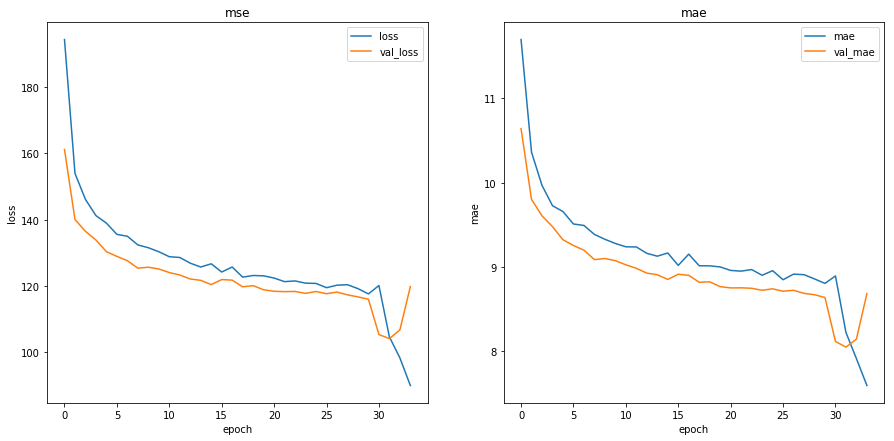

In [31]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2 ,1)
plt.title('mse')
plt.plot(all_loss, label='loss')
plt.plot(all_val_loss, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('mae')
plt.plot(all_mae, label='mae')
plt.plot(all_val_mae, label='val_mae')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend()

plt.show()